<a href="https://colab.research.google.com/github/aliash98/Search2Vec/blob/main/Search2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting Up Dependencies**


## Installing Libraries

In [ ]:
!pip install pandas
!pip install numpy

## Importing

In [ ]:
import matplotlib.pyplot as plt
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import json
import re
import warnings
import gc 
from tqdm import tqdm, trange

## Some Configuration:

In [ ]:
warnings.filterwarnings("ignore") # do not display warnings at all

pd.set_option('display.max_column',500) # sets the maximum number of columns displayed when a frame is pretty-printed. Truncated lines are replaced by an ellipsis.
pd.set_option('display.expand_frame_repr',False) # allows for the representation of dataframes to stretch across pages, wrapped over the full column vs row-wise.
pd.set_option('display.width',1000) # Width of the display in characters. 
pd.set_option('max_colwidth',500) # sets the maximum width of columns. Cells of this length or longer will be truncated with an ellipsis.

# **Preparing Data**

## Reading Data from Drive

In [ ]:
!gdown --id 1W87y-JeBUfyCdsT8uF32rrx0STmfdLYZ
!7z x torob_dataset.7z

Downloading...
From: https://drive.google.com/uc?id=1W87y-JeBUfyCdsT8uF32rrx0STmfdLYZ
To: /content/torob_dataset.7z
295MB [00:03, 94.4MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 295162437 bytes (282 MiB)

Extracting archive: torob_dataset.7z
--
Path = torob_dataset.7z
Type = 7z
Physical Size = 295162437
Headers Size = 315
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 3 - train/base_products.json                                   1% 3 - train/base_products.json                                   2% 3 - train/base_products.json                                 

## Placing into DataFrames

In [ ]:
def read_lowmem(path):
  with open(path) as f:
    res = [json.loads(line) for line in tqdm(f)]
    res = pd.DataFrame(res)
  return res  

product = read_lowmem('train/base_products.json')
click = read_lowmem('train/click_log_train.json') 
search = read_lowmem('train/search_log_train.json') 

# Garbage collector
gc.collect()

1985152it [00:35, 55407.63it/s]
6317934it [00:30, 209268.11it/s]
3694579it [00:49, 74310.83it/s] 


0

Optional slicing of data for releasing the RAM

In [ ]:
h_product = product.head(10000).copy()
h_click = click.head(10000).copy()
h_search = search.head(10000).copy()
del product
del click
del search
gc.collect()

230

In [ ]:
h_product.info()
h_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   _id            10000 non-null  object
 1   category_name  10000 non-null  object
 2   sellers        10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   datetime         10000 non-null  object
 1   search_log_id    10000 non-null  object
 2   rank             10000 non-null  int64 
 3   base_product_id  10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


## Defining Useful Columns


> 1- Conversion of Dates


> 2- Defining "nsellers" as number of sellers for each product








In [ ]:
search['datetime'] = [datetime.fromisoformat(d) for d in search.datetime]
click['datetime'] = [datetime.fromisoformat(d) for d in click.datetime]
product['nsellers'] = [len(p) for p in product.sellers]
product = product[product.nsellers > 0]

# **Overview on Input Data**

## Basic Information about each dataset

In [ ]:
print(search.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694579 entries, 0 to 3694578
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   _id        object        
 1   raw_query  object        
 2   page       int64         
 3   result     object        
 4   datetime   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 140.9+ MB
None


In [ ]:
print(click.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6317934 entries, 0 to 6317933
Data columns (total 4 columns):
 #   Column           Dtype         
---  ------           -----         
 0   datetime         datetime64[ns]
 1   search_log_id    object        
 2   rank             int64         
 3   base_product_id  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 192.8+ MB
None


In [ ]:
print(product.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1769291 entries, 0 to 1985151
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   _id            object
 1   category_name  object
 2   sellers        object
 3   nsellers       int64 
dtypes: int64(1), object(3)
memory usage: 67.5+ MB
None


## Heads
A few first datas of 'search', 'click' and 'product' datasets:

In [ ]:
search.head()

,_id,raw_query,page,result,datetime
0,609d7e3a6c2e88f6b241b089,گوشی موبایل,3,"[mmmmm, mmmmy, mmmmu, mmmmk, mmmmb, mmmma, mmmmt, mmmmz, mmmmd, mmmmf]",2021-05-13 19:30:02.664
1,609d7e4802589dff17211ce4,گوشی,38,"[mmmmn, mmmmi, mmmmo, mmmmx, mmmms, mmmmw, mmmme, mmmmr, mmmmc]",2021-05-13 19:30:16.244
2,609d7e4aa0194216c0994b29,گوشی سامسونگ,0,"[mmmmq, mmmmv, mmmml, mmmmp, mmmmj, mmmmh, mmmym, mmmyy, mmmmu, mmmyu]",2021-05-13 19:30:18.246
3,609d7e58efd179e80a6fcd99,گوشی,39,"[mmmka, mmmkz, mmmkf, mmmkg, mmmkx]",2021-05-13 19:30:32.254
4,609d7e5b8c23961847786454,گوشی,7,"[mmmks, mmmkw, mmmke, mmmkr, mmmkc, mmmkq, mmmkv, mmmkl, mmmkp, mmmkj]",2021-05-13 19:30:35.460


In [ ]:
click.head()

,datetime,search_log_id,rank,base_product_id
0,2021-05-13 19:30:47.249,609d7e4802589dff17211ce4,386,mmmmw
1,2021-05-13 19:31:14.383,609d7e58efd179e80a6fcd99,394,mmmkf
2,2021-05-13 19:31:56.974,609d7e3a6c2e88f6b241b089,34,mmmmb
3,2021-05-13 19:32:13.437,609d7eac2bf9491ab8fa0275,444,mmmtq
4,2021-05-13 19:32:14.086,609d7ea747bd1ff6b3eac1ba,4,mmmmq


In [ ]:
product.head()

,_id,category_name,sellers,nsellers
0,yxwrs,ویدیو پروژکتور اپتما,"[{'name1': 'پروژکتور Optoma HD142X 1080p 3000 Lumens 3D DLP صفحه اصلی سینمای خانگی', 'name2': 'Optoma HD142X 1080p 3000 Lumens 3D DLP Home Theater Projector', 'price': 31852600, 'availability': True, 'date_added': '2018-06-10T17:27:45.418776+00:00'}, {'name1': 'ویدئو پروژکتور اوپتوما optoma hd142x : خانگی، 3D، رزولوشن 1920x1080 HD', 'name2': '', 'price': 12645000, 'availability': False, 'date_added': '2018-05-24T16:59:16.465159+00:00'}, {'name1': 'Video Projector Optoma HD142X', 'name2': 'دی...",6
1,mbeby,تقویت کننده مژه و ابرو,"[{'name1': 'ژل حالت دهنده ابرو و مژه essence', 'name2': 'Essence Lash And Brow Gel', 'price': 60000, 'availability': True, 'date_added': '2020-06-29T20:02:26.427948+00:00'}, {'name1': 'ژل حالت دهنده ابرو و مژه اسنس', 'name2': 'ESSENCE LASH AND BROW GEL', 'price': 65000, 'availability': False, 'date_added': '2021-02-07T16:00:26.664478+00:00'}, {'name1': 'ژل ابرو اسنس', 'name2': '', 'price': 98000, 'availability': True, 'date_added': '2021-03-10T12:18:51.632557+00:00'}, {'name1': 'ژل حالت دهند...",33
2,yovgc,مام و اسپری,"[{'name1': 'استیک مردانه وی ایت رکسونا V8', 'name2': 'REXONA Men Stick V8', 'price': 0, 'availability': False, 'date_added': '2020-04-30T17:09:55.121061+00:00'}, {'name1': 'استیک دئودرانت مردانه رکسونا مدل V8 Tuning', 'name2': '', 'price': 60000, 'availability': False, 'date_added': '2020-05-14T15:16:17.862829+00:00'}, {'name1': 'استیک ضد تعریق مردانه رکسونا مدل V8 وزن 40 گرم', 'name2': '', 'price': 30000, 'availability': False, 'date_added': '2019-04-30T19:05:27.777683+00:00'}, {'name1': 'د...",5
3,yokff,مام و اسپری,"[{'name1': 'مام صابونی رکسونا زنانه کاتون درای الگودون Rexona Deodorant Cotton Dry Algodon', 'name2': '', 'price': 49000, 'availability': True, 'date_added': '2020-04-14T15:01:10.103048+00:00'}, {'name1': 'استیک ضد تعریق مدل Cotton Dry رکسونا حجم 40 میل', 'name2': 'Rexona Cotton Dry Stick Deodorant 40ml', 'price': 50000, 'availability': True, 'date_added': '2020-06-07T14:50:38.449131+00:00'}, {'name1': 'استیک ضد تعریق زنانه رکسونا مدل cotton dry حجم 40 میل', 'name2': '', 'price': 45000, 'ava...",16
4,uduyq,گوشی هوآوی,"[{'name1': 'Huawei Ascend Y550', 'name2': 'Huawei Ascend Y550', 'price': 0, 'availability': False, 'date_added': '2017-04-24T19:33:29.044830+00:00'}, {'name1': 'گوشی موبایل هواوی HUAWEI ASCEND Y550', 'name2': '', 'price': 0, 'availability': False, 'date_added': '2018-03-12T10:26:23.683039+00:00'}, {'name1': 'گوشی موبایل هواوی اسند وای 550', 'name2': '', 'price': 0, 'availability': False, 'date_added': '2017-06-02T01:46:01.935024+00:00'}, {'name1': 'گوشی موبایل هوآوی Huawei Ascend Y550', 'nam...",5


# **Analysis**

## Ranking Performance

> By plotting the correlation between the given ranks and clicks to each product, we notice the proper accuracy of ranking algorithm.



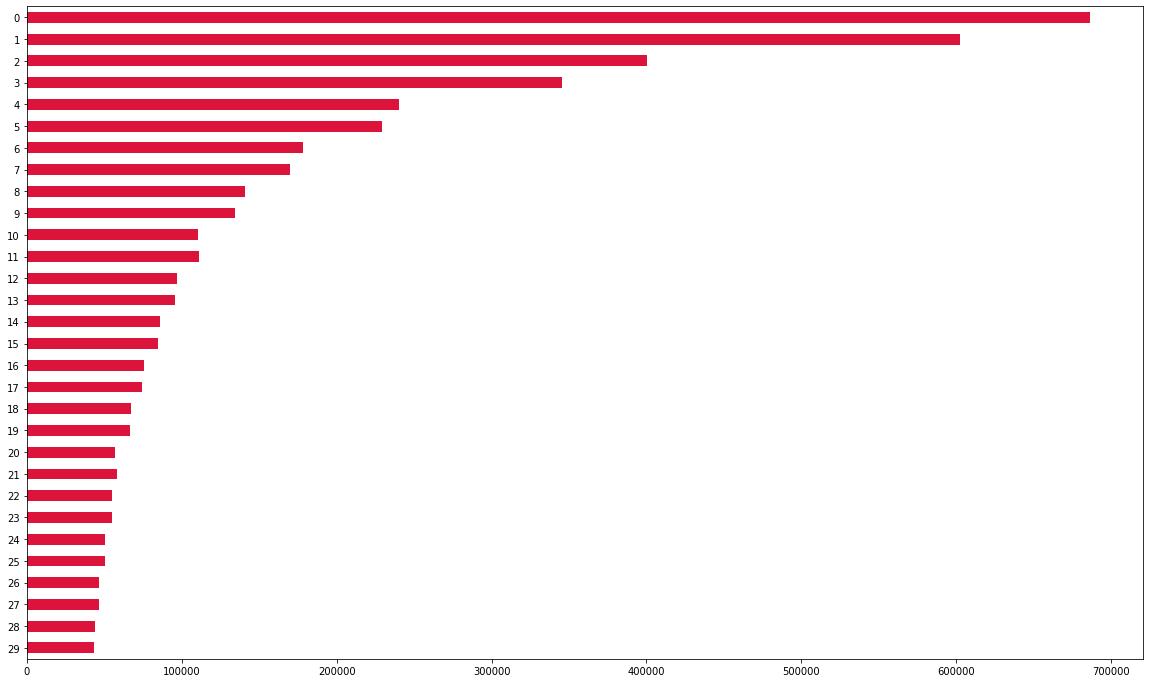

In [ ]:
plt.figure(figsize=(20,12))
click["rank"].value_counts().sort_index()[:30].plot.barh(color = 'crimson').invert_yaxis()
plt.show()



> The relation between clicks and page numbers related to each click, we'll see that most of clicks are appeared on few first pages



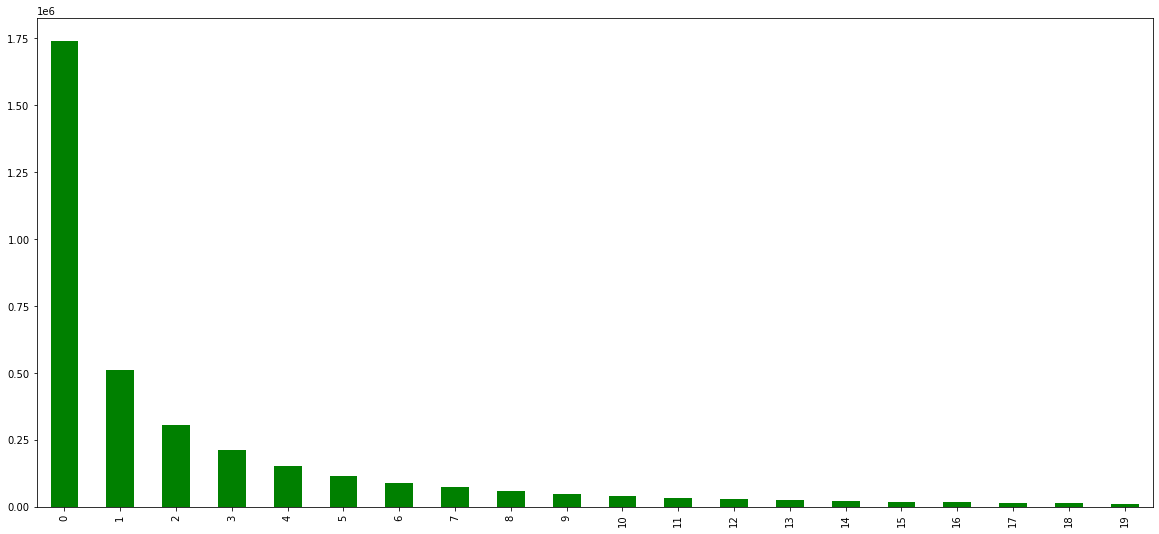

In [ ]:
plt.figure(figsize=(20,9))
search.page.value_counts()[0:20].plot.bar(color = 'green')
plt.show()

## Abundance of Products in Each Category

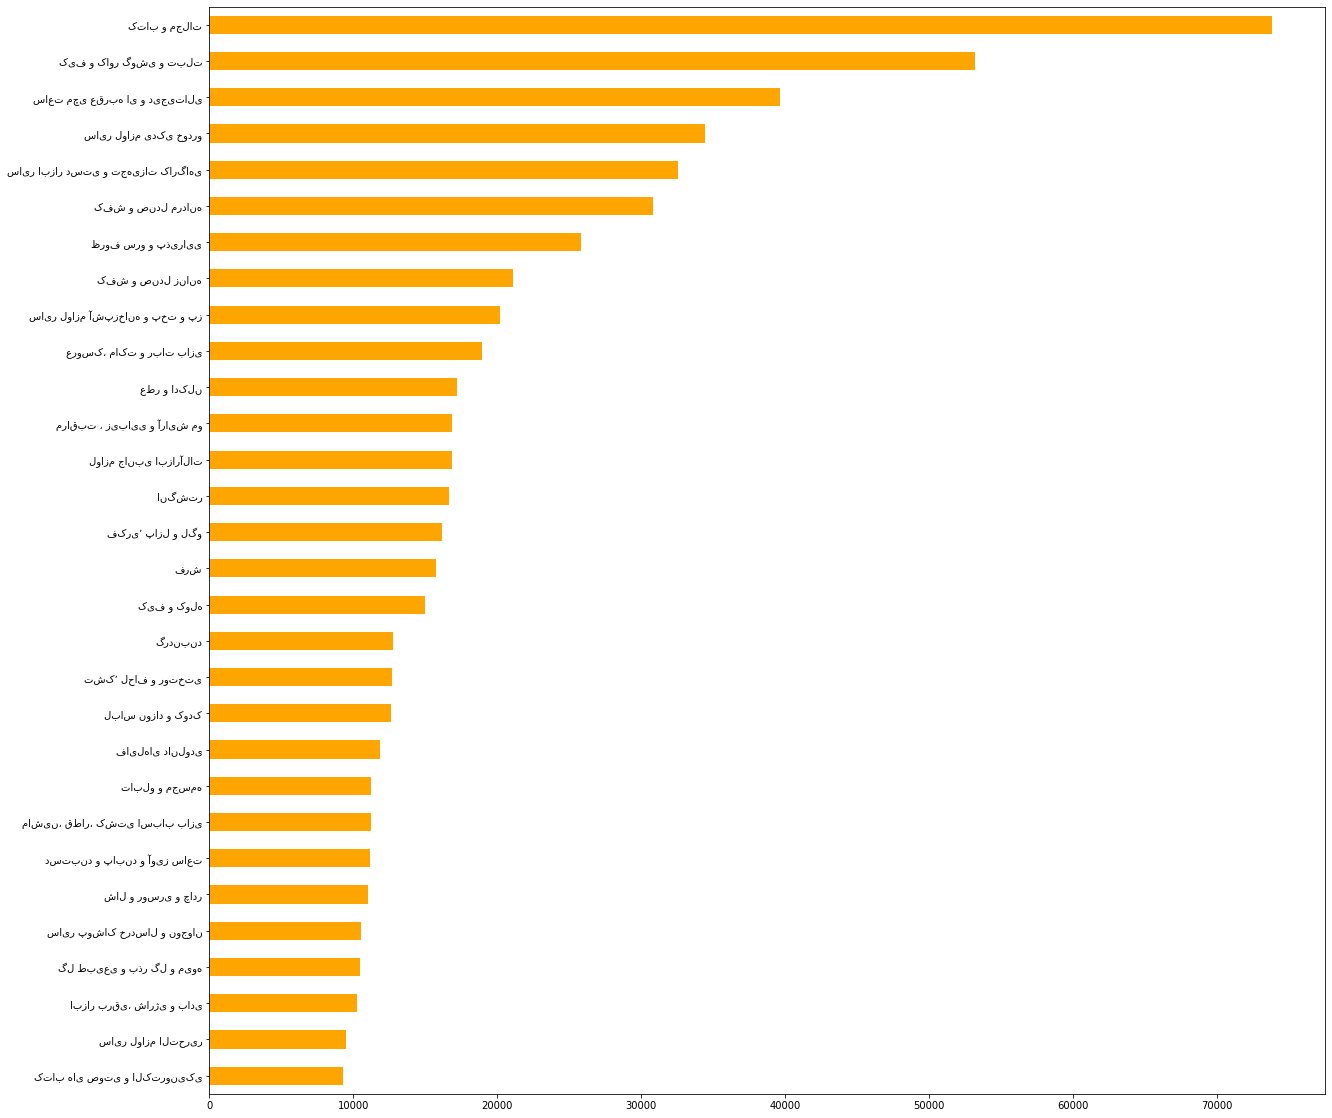

In [ ]:
plt.figure(figsize=(20,20))
product.category_name.value_counts()[:30].plot.barh(color = 'orange').invert_yaxis()
plt.show()

## Considering a 24 h Period


> Analayzing searches and clicks regarding to a random 24 hour:



In [ ]:
from_date = datetime.strptime('5/5/2021 00:00:00', '%d/%m/%Y %H:%M:%S')
to_date = datetime.strptime('6/5/2021 00:00:00', '%d/%m/%Y %H:%M:%S')

print(from_date, to_date)

2021-05-05 00:00:00 2021-05-06 00:00:00


In [ ]:
search = search[[from_date < d < to_date for d in search.datetime]]
click = click[[from_date < d < to_date for d in click.datetime]]

In [ ]:
# Retrieving products shown in search results in this period
needed_product_ids = set(itertools.chain(*[set(r) for r in search.result]))
product = product[[idx in needed_product_ids for idx in product._id]]
len(needed_product_ids), len(product)

(256568, 256568)

Modifying clicks is this period:

In [ ]:
search = search[["_id","raw_query", "result"]]
gc.collect()
def extract_name_1(x):
    try:
        return x[0]['name1']
    except:
        return 'no name'
def extract_name_2(x):
    try:
        return x[0]['name2']
    except:
        return 'no name'
def extract_price(x):
    try:
        return x[0]['price']
    except:
        return -999
def extract_date(x):
    try:
        return x[0]['date_added']
    except:
        return '2022-01-01'
click = pd.merge(click, product, how='left', left_on='base_product_id', right_on='_id')
click['product_name_1'] = click['sellers'].apply(extract_name_1)
click['product_name_2'] = click['sellers'].apply(extract_name_2)
click['price'] = click['sellers'].apply(extract_price)
click['date'] = click['sellers'].apply(extract_date)

In [ ]:
click[click.columns[~click.columns.isin(['sellers'])]].head(3)
# Sellers column is not shown because of its dirty appearance

,datetime,search_log_id,rank,base_product_id,_id,category_name,nsellers,product_name_1,product_name_2,price,date
0,2021-05-05 19:31:53.866,6092f282af85a6df5d6ed9c8,27,mmmyy,mmmyy,گوشی سامسونگ,260.0,Samsung Galaxy A12 128GB,Samsung Galaxy A12 128GB,4020000,2021-01-08T01:57:36.574557+00:00
1,2021-05-05 19:32:06.366,6092f2a5d666e955ea0af30d,486,muyhc,muyhc,سایر برندهای گوشی موبایل,1.0,گوشی موبایل تاشو VNUS V100,,500000,2020-10-18T09:12:57.064705+00:00
2,2021-05-05 19:33:31.715,6092f238778372a51a4c221a,374,mynlp,mynlp,گوشی نوکیا,1.0,گوشی Nokia 6303,,250000,2021-04-28T20:53:15.486780+00:00


## Pie Plot of First Rank When Query is "گوشی"

In [ ]:
gc.collect()
click_analysis = pd.merge(click , search, how="inner" , left_on="search_log_id" , right_on="_id")

click_analysis = click_analysis.drop_duplicates(['search_log_id', 'rank', 'category_name', 'raw_query'])
a0 = click_analysis[(click_analysis.raw_query == "گوشی")&(click_analysis["rank"]==0)].category_name.value_counts()[:8]
fig,ax = plt.subplots(figsize=(7, 7))
a=0
b=0
colors = ['#ff9999','#66b3ff','#99ff99']
# plt.pie(a0,[0,0,0,0.2,0.3,0.4,0.5,1.4], labels=a0.index)
plt.pie(a0,[0,0.5,0.7], labels=a0.index, shadow=True, colors = colors)
plt.show()

NameError: ignored